In [40]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
# import model
import csv
from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

if not torch.cuda.is_available():
    from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

shape = (44, 44)


class DataSetFactory:

    def __init__(self):
        images = []
        emotions = []
        private_images = []
        private_emotions = []
        public_images = []
        public_emotions = []

        with open('/content/dataset/fer2013_balanced.csv', 'r') as csvin:
            data = csv.reader(csvin)
            next(data)
            for row in data:
                face = [int(pixel) for pixel in row[1].split()]
                face = np.asarray(face).reshape(48,48)
                face = face.astype('uint8')

                if row[-1] == 'Training':
                    emotions.append(int(row[0]))
                    images.append(Image.fromarray(face))
                elif row[-1] == "PrivateTest":
                    private_emotions.append(int(row[0]))
                    private_images.append(Image.fromarray(face))
                elif row[-1] == "PublicTest":
                    public_emotions.append(int(row[0]))
                    public_images.append(Image.fromarray(face))

        print('training size %d : private val size %d : public val size %d' % (
            len(images), len(private_images), len(public_images)))
        train_transform = transforms.Compose([
            transforms.RandomCrop(shape[0]),
            transforms.RandomHorizontalFlip(),
            ToTensor(),
        ])
        val_transform = transforms.Compose([
            transforms.CenterCrop(shape[0]),
            ToTensor(),
        ])

        self.training = DataSet(transform=train_transform, images=images, emotions=emotions)
        self.private = DataSet(transform=val_transform, images=private_images, emotions=private_emotions)
        self.public = DataSet(transform=val_transform, images=public_images, emotions=public_emotions)

    def get_training_data(self):
        return self.training.images, self.training.emotions


    def get_class_distribution(self):
        # Count the number of occurrences of each emotion in the training set
        emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
        emotion_counts = {emotion: 0 for emotion in range(len(emotion_labels))}
        for emotion in self.training.emotions:
            emotion_counts[emotion] += 1
        return emotion_counts

In [41]:
class DataSet(torch.utils.data.Dataset):

    def __init__(self, transform=None, images=None, emotions=None):
        self.transform = transform
        self.images = images
        self.emotions = emotions

    def __getitem__(self, index):
        image = self.images[index]
        emotion = self.emotions[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, emotion

    def __len__(self):
        return len(self.images)

training size 29465 : private val size 3738 : public val size 3688


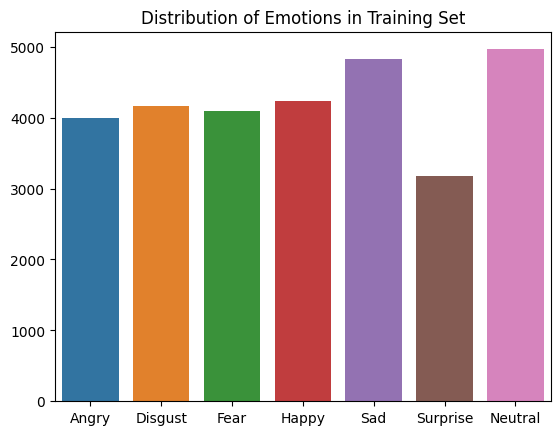

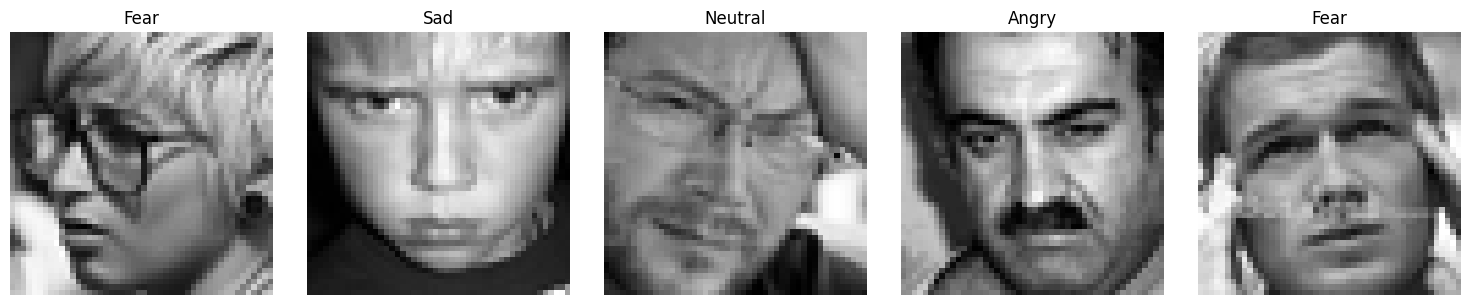

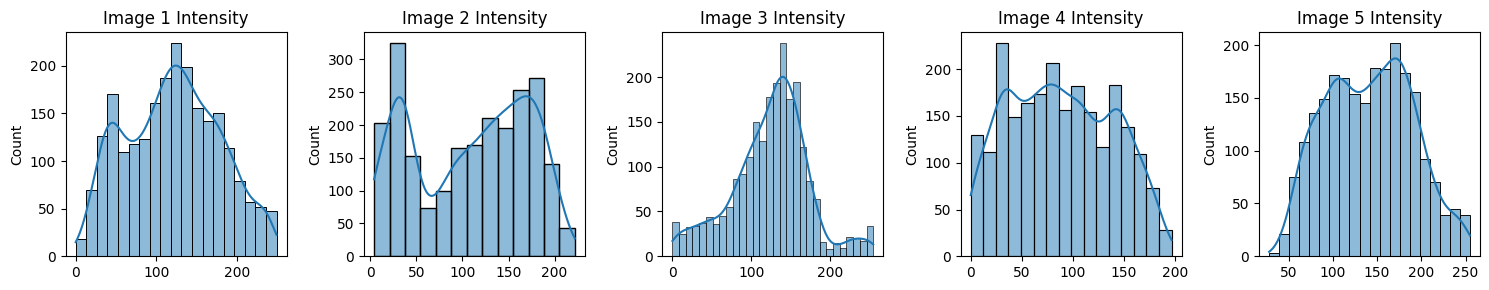

In [45]:
# from original_train import DataSetFactory  # Import the modified DataSetFactory
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Instantiate DataSetFactory and get training data
factory = DataSetFactory()
train_images, train_emotions = factory.get_training_data()

# Emotion Distribution
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
emotion_counts = np.bincount(train_emotions)
sns.barplot(x=emotion_labels, y=emotion_counts)
plt.title("Distribution of Emotions in Training Set")
plt.show()

# Show Sample Images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(train_images[i], cmap='gray')
    ax.set_title(emotion_labels[train_emotions[i]])
    ax.axis('off')
plt.tight_layout()
plt.show()

# Pixel Intensity Distribution
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    img_array = np.asarray(train_images[i])
    sns.histplot(img_array.flatten(), ax=ax, kde=True)
    ax.set_title(f'Image {i+1} Intensity')
plt.tight_layout()
plt.show()


In [39]:
from torch.utils.data import WeightedRandomSampler

# Assuming 'emotions' is a list of all your emotion labels for the training data
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
emotion_counts = [emotions.count(x) for x in range(len(emotion_labels))]

# Calculate weights for each class
total_samples = len(emotions)
weights = [total_samples/emotion_counts[emotion] for emotion in emotions]

# Create a WeightedRandomSampler object
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# Use the sampler in the DataLoader
training_loader = DataLoader(factory.training, batch_size=batch_size, shuffle=False, sampler=sampler, num_workers=args.n)


NameError: ignored

In [42]:
factory = DataSetFactory()
emotion_counts = factory.get_class_distribution()

training size 27785 : private val size 3497 : public val size 3491


In [17]:
emotion_counts

{0: 3995, 1: 436, 2: 4097, 3: 7215, 4: 4830, 5: 3171, 6: 4965}

In [44]:
import pandas as pd
from sklearn.utils import resample

# Load the dataset
df = pd.read_csv('/content/dataset/fer2013.csv')

# Separate the dataset by emotion
df_disgust = df[df['emotion'] == 1]  # Assuming 'Disgust' is labeled as 1
df_happy = df[df['emotion'] == 3]    # Assuming 'Happy' is labeled as 3
df_other = df[(df['emotion'] != 1) & (df['emotion'] != 3)]

target_sample_size = 5270

# Upsample the 'Disgust' class
df_disgust_upsampled = resample(df_disgust,
                                replace=True,               # sample with replacement
                                n_samples=target_sample_size,    # to match number of 'Happy' class
                                random_state=123)           # reproducible results

# Downsample the 'Happy' class
df_happy_downsampled = resample(df_happy,
                                replace=False,              # sample without replacement
                                n_samples=target_sample_size,  # to match number of 'Disgust' class
                                random_state=123)           # reproducible results

# Combine the modified instances with the rest of the dataset
df_balanced = pd.concat([df_other, df_disgust_upsampled, df_happy_downsampled])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=123).reset_index(drop=True)

# Save the new balanced dataset to a new CSV file
df_balanced.to_csv('/content/dataset/fer2013_balanced.csv', index=False)


In [38]:
print(df_balanced['emotion'].value_counts())

6    6198
4    6077
2    5121
0    4953
1    4211
3    4211
5    4002
Name: emotion, dtype: int64


In [43]:
print(df['emotion'].value_counts())

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64
